# MicroHapDB: marker attributes

This notebook was used to generate figures for the MicroHapDB paper (Standage & Mitchell, 2020).

In [1]:
%matplotlib inline
from collections import defaultdict
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator
import microhapdb
import numpy
import seaborn

In [2]:
microhapdb.__version__

'0.5+2.g1685e48'

First, make a copy of the `markers` table and compute marker lengths

In [3]:
m = microhapdb.markers.copy()
m['Start'] = m.Offsets.apply(lambda x: min(map(int, x.split(','))))
m['End'] = m.Offsets.apply(lambda x: max(map(int, x.split(','))) + 1)
m['Length'] = m.apply(lambda x: x.End - x.Start, axis=1)

Next, define labels and colors for the stacked histogram plots.

In [4]:
sources = m.Source.unique()
labels = {
    'ALFRED':                         'ALFRED (2018)',
    '10.1016/j.fsigen.2019.02.018':   'Chen (2019)',
    '10.1016/j.legalmed.2015.06.003': 'Hiroaki (2015)',
    '10.1016/j.fsigen.2019.102213':   'USC (2020)',
    'ISFG2019:P597':                  'ISFG P597 (2019)',
    '10.1016/j.fsigen.2018.05.008':   'van der Gaag (2018)',
    '10.1016/j.fsigen.2018.05.001':   'Voskoboinik (2018)'
}
colors = [
    '#9b59b6',
    '#3498db',
    '#95a5a6',
    '#e74c3c',
    '#34495e',
    '#2ecc71',
    '#feb308',
]
subsets = [m[m.Source == src] for src in sources]

Compute distances between each marker and its closest non-overlapping marker.

In [5]:
def overlap(start1, end1, start2, end2):
    return start1 < end2 and end1 > start2

def distance(start1, end1, start2, end2):
    if overlap(start1, end1, start2, end2):
        return -1
    if start1 > start2:
        start1, end1, start2, end2 = start2, end2, start1, end1
    return start2 - end1

In [6]:
distances = defaultdict(list)
overlapping = set()
pairs = list()
for chrom in sorted(m.Chrom.unique()):
    cm = m[m.Chrom == chrom]
    for x, rowi in cm.iterrows():
        dist = None
        for y, rowj in cm.iterrows():
            if x == y:
                continue
            tempdist = distance(rowi.Start, rowi.End, rowj.Start, rowj.End)
            if tempdist < 0:
                overlapping.add(rowi.Name)
                if x < y:
                    pairs.append(tuple(sorted((rowi.Source, rowj.Source))))
                continue
            if dist is None or tempdist < dist:
                dist = tempdist
        assert dist is not None, rowi
        distances[rowi.Source].append(dist)

distlists = list()
for src in sources:
    sourcelist = [d / 1e6 for d in distances[src] if d < 25e6]
    distlists.append(sourcelist)

Finally, plot the data.

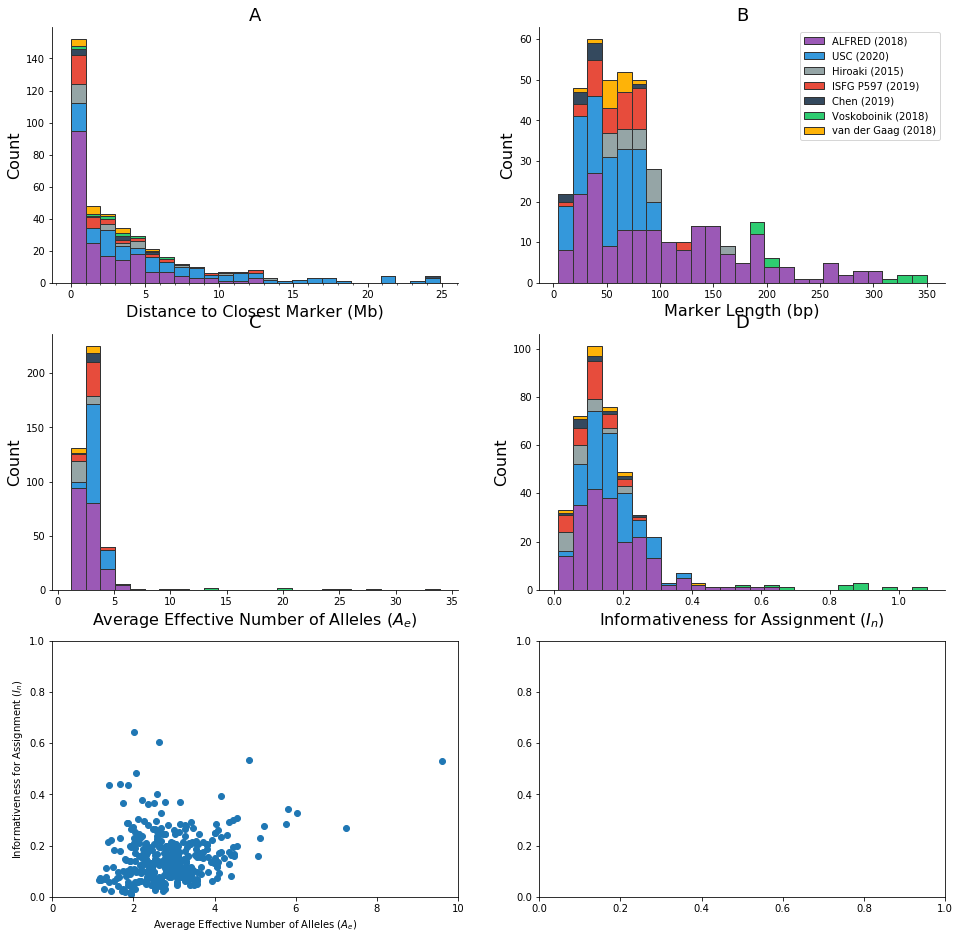

In [10]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 16))
fig.patch.set_facecolor('white')

plots = (2, 3, 4)
attributes = ('Length', 'AvgAe', 'In')
xlabels = (
    'Marker Length (bp)',
    'Average Effective Number of Alleles ($A_e$)',
    'Informativeness for Assignment ($I_n$)'
)
legendlabels = [labels[src] for src in sources]

axis = plt.subplot(3, 2, 1)
plt.hist(distlists, color=colors, edgecolor='#333333', bins=25, stacked=True, label=legendlabels)
axis = plt.gca()
axis.spines['top'].set_visible(False)
axis.spines['right'].set_visible(False)
axis.xaxis.set_minor_locator(MultipleLocator(1))
axis.set_xlabel('Distance to Closest Marker (Mb)', fontsize=16)
axis.set_ylabel('Count', fontsize=16)
axis.set_title('A', fontsize=18)

for plotn, attribute, xlabel in zip(plots, attributes, xlabels):
    axis = plt.subplot(3, 2, plotn)
    data = [ss[attribute] for ss in subsets]
    plt.hist(
        data, color=colors, edgecolor='#333333', bins=25,
        stacked=True, label=legendlabels
    )
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)
    axis.set_xlabel(xlabel, fontsize=16)
    axis.set_ylabel('Count', fontsize=16)
    axis.set_title(chr(plotn + 64), fontsize=18)
    if plotn == 2:
        _ = axis.legend()

axis = plt.subplot(3, 2, plotn + 1)
plt.scatter(m.AvgAe, m.In)
axis.set_xlabel('Average Effective Number of Alleles ($A_e$)')
axis.set_ylabel('Informativeness for Assignment ($I_n$)')
axis.set_xlim((0, 10))
axis.set_ylim((0, 1))

fig.savefig('mh-attributes.pdf')

And display a few summary statistics.

In [7]:
allmarkers = m
markers_lt100bp = m[m.Length < 100]
markers_lt50bp = m[m.Length < 50]
markers_3ltaelt5 = m[(m.AvgAe > 3.0) & (m.AvgAe < 5.0)]

In [8]:
allmarkers[['Length', 'AvgAe', 'In']].describe()

,Length,AvgAe,In
count,417.000000,412.000000,412.000000
mean,86.059952,3.278895,0.169632
std,66.850535,3.008697,0.139398
min,4.000000,1.158200,0.010200
25%,41.000000,2.328250,0.095200
50%,69.000000,2.864750,0.138600
75%,104.000000,3.322100,0.205725
max,350.000000,33.919000,1.081000


In [9]:
print(len(markers_lt100bp), '/', len(allmarkers), len(markers_lt100bp) / len(allmarkers))
markers_lt100bp[['Length', 'AvgAe', 'In']].describe()

307 / 417 0.7362110311750599


,Length,AvgAe,In
count,307.000000,302.000000,302.000000
mean,53.074919,2.828806,0.139366
std,24.364825,0.706573,0.080361
min,4.000000,1.158200,0.010200
25%,33.000000,2.338975,0.089800
50%,50.000000,2.895950,0.124100
75%,73.000000,3.273350,0.177075
max,99.000000,6.026900,0.642300


In [10]:
print(len(markers_lt50bp), '/', len(allmarkers), len(markers_lt50bp) / len(allmarkers))
markers_lt50bp[['Length', 'AvgAe', 'In']].describe()

145 / 417 0.34772182254196643


,Length,AvgAe,In
count,145.000000,144.000000,144.000000
mean,31.255172,2.812634,0.133542
std,11.456912,0.580214,0.079869
min,4.000000,1.162600,0.020100
25%,22.000000,2.467100,0.084650
50%,32.000000,2.859850,0.122800
75%,42.000000,3.169000,0.162950
max,49.000000,4.554400,0.642300


In [11]:
print(len(markers_3ltaelt5), '/', len(allmarkers), len(markers_3ltaelt5) / len(allmarkers))
markers_3ltaelt5[['Length', 'AvgAe', 'In']].describe()

157 / 417 0.3764988009592326


,Length,AvgAe,In
count,157.000000,157.000000,157.000000
mean,78.541401,3.504339,0.152717
std,56.000972,0.432034,0.074074
min,5.000000,3.007000,0.044400
25%,42.000000,3.142100,0.101700
50%,67.000000,3.371600,0.140700
75%,87.000000,3.720000,0.191500
max,296.000000,4.845900,0.536400


# Sandbox

Everything below this cell is an informal sandbox.

Text(0, 0.5, 'Frequency')

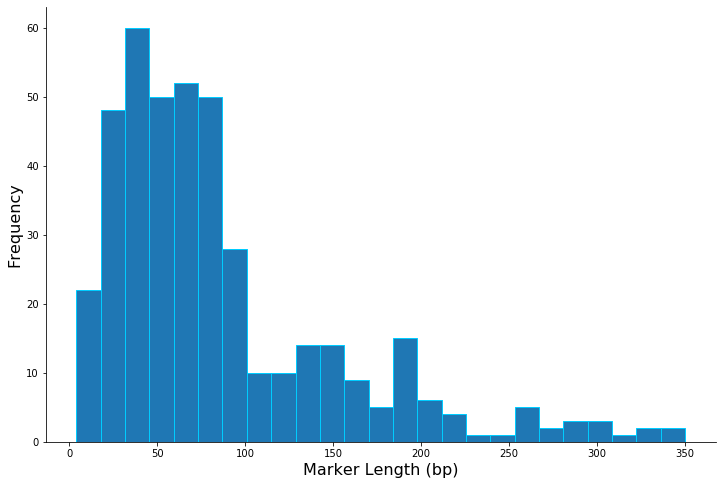

In [12]:
fig = plt.figure(figsize=(12, 8))
fig.patch.set_facecolor('white')
plt.hist(m.Length, bins=25, edgecolor='#00ccff')
axis = plt.gca()
axis.spines['top'].set_visible(False)
axis.spines['right'].set_visible(False)
axis.set_xlabel('Marker Length (bp)', fontsize=16)
axis.set_ylabel('Frequency', fontsize=16)

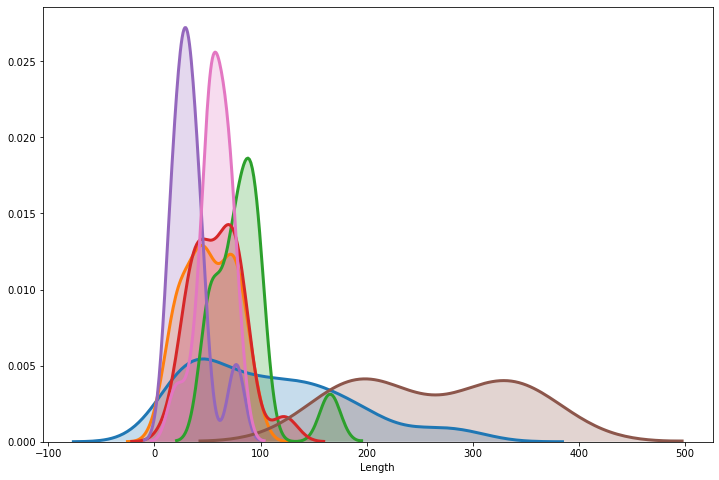

In [13]:
fig = plt.figure(figsize=(12, 8))
for src in m.Source.unique():
    subset = m[m.Source == src]
    seaborn.distplot(subset.Length, hist=False, kde=True,
                     kde_kws={'shade': True, 'linewidth': 3})

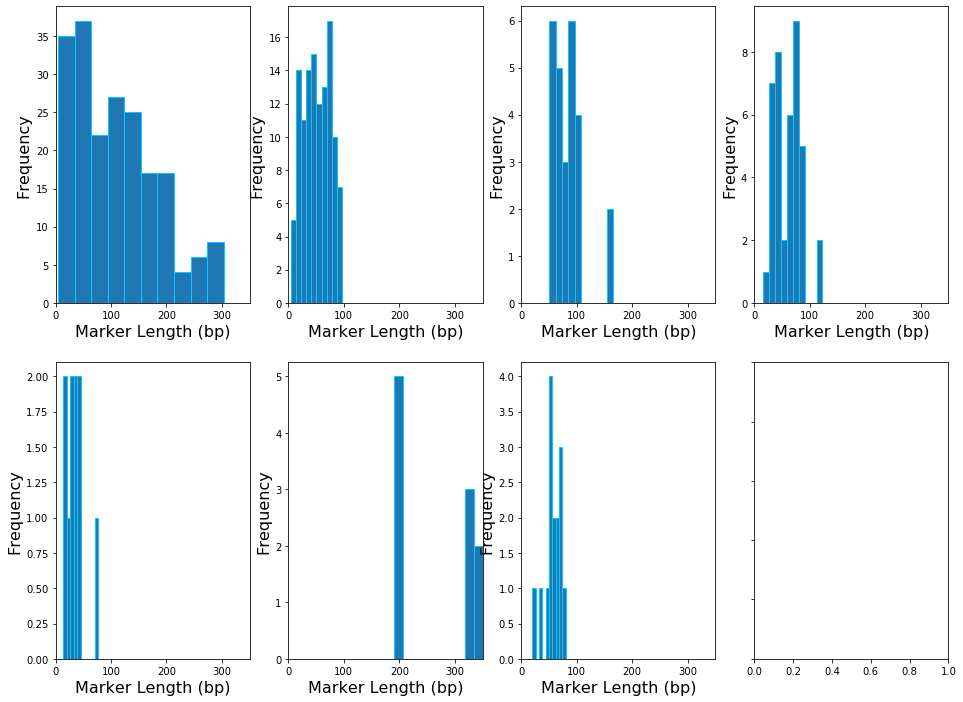

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=4, sharey=True, figsize=(16, 12))
for n, src in enumerate(m.Source.unique()):
    axis = plt.subplot(2, 4, n + 1)
    subset = m[m.Source == src]
    axis.hist(subset.Length, edgecolor='#00ccff')
    axis.set_xlim((0, 350))
    axis.set_xlabel('Marker Length (bp)', fontsize=16)
    axis.set_ylabel('Frequency', fontsize=16)

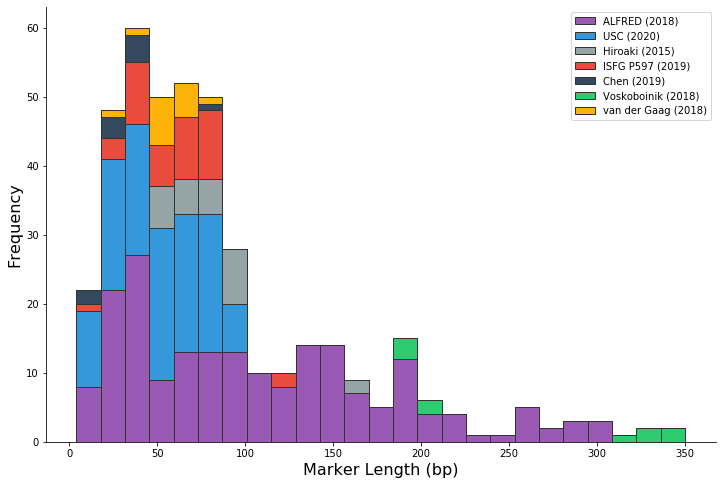

In [15]:
sources = m.Source.unique()
labels = {
    'ALFRED': 'ALFRED (2018)',
    '10.1016/j.fsigen.2019.02.018': 'Chen (2019)',
    '10.1016/j.legalmed.2015.06.003': 'Hiroaki (2015)',
    '10.1016/j.fsigen.2019.102213': 'USC (2020)',
    'ISFG2019:P597': 'ISFG P597 (2019)',
    '10.1016/j.fsigen.2018.05.008': 'van der Gaag (2018)',
    '10.1016/j.fsigen.2018.05.001': 'Voskoboinik (2018)'
}
colors = [
    '#9b59b6',
    '#3498db',
    '#95a5a6',
    '#e74c3c',
    '#34495e',
    '#2ecc71',
    '#feb308',
]
subsets = [m[m.Source == src] for src in sources]
fig = plt.figure(figsize=(12, 8))
fig.patch.set_facecolor('white')
plt.hist([ss.Length for ss in subsets], color=colors, edgecolor='#333333', bins=25, stacked=True, label=[labels[src] for src in sources])
axis = plt.gca()
axis.spines['top'].set_visible(False)
axis.spines['right'].set_visible(False)
axis.set_xlabel('Marker Length (bp)', fontsize=16)
axis.set_ylabel('Frequency', fontsize=16)
axis.legend()
fig.savefig('mh-lengths.pdf')

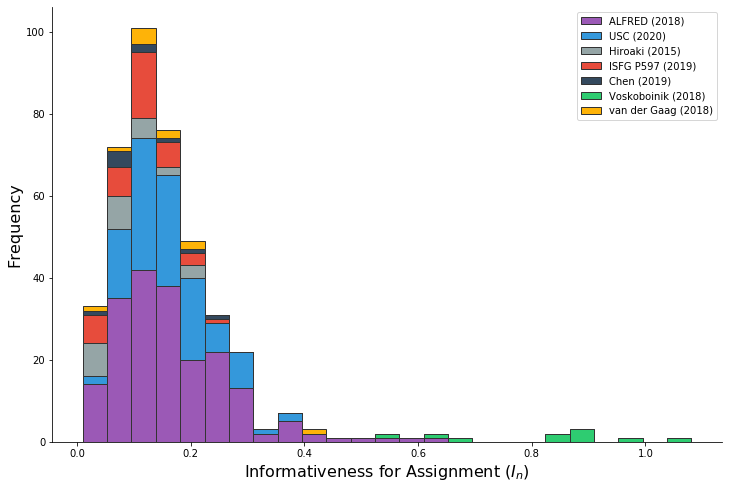

In [16]:
sources = m.Source.unique()
labels = {
    'ALFRED': 'ALFRED (2018)',
    '10.1016/j.fsigen.2019.02.018': 'Chen (2019)',
    '10.1016/j.legalmed.2015.06.003': 'Hiroaki (2015)',
    '10.1016/j.fsigen.2019.102213': 'USC (2020)',
    'ISFG2019:P597': 'ISFG P597 (2019)',
    '10.1016/j.fsigen.2018.05.008': 'van der Gaag (2018)',
    '10.1016/j.fsigen.2018.05.001': 'Voskoboinik (2018)'
}
colors = [
    '#9b59b6',
    '#3498db',
    '#95a5a6',
    '#e74c3c',
    '#34495e',
    '#2ecc71',
    '#feb308',
]
subsets = [m[m.Source == src] for src in sources]
fig = plt.figure(figsize=(12, 8))
fig.patch.set_facecolor('white')
plt.hist([ss.In for ss in subsets], color=colors, edgecolor='#333333', bins=25, stacked=True, label=[labels[src] for src in sources])
axis = plt.gca()
axis.spines['top'].set_visible(False)
axis.spines['right'].set_visible(False)
axis.set_xlabel('Informativeness for Assignment ($I_n$)', fontsize=16)
axis.set_ylabel('Frequency', fontsize=16)
axis.legend()
fig.savefig('mh-in.pdf')

/Users/daniel.standage/anaconda3/envs/microhapulator/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


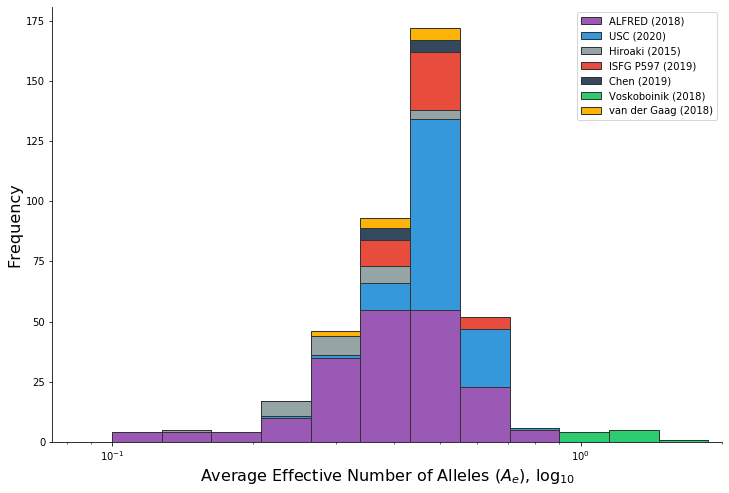

In [17]:
sources = m.Source.unique()
labels = {
    'ALFRED': 'ALFRED (2018)',
    '10.1016/j.fsigen.2019.02.018': 'Chen (2019)',
    '10.1016/j.legalmed.2015.06.003': 'Hiroaki (2015)',
    '10.1016/j.fsigen.2019.102213': 'USC (2020)',
    'ISFG2019:P597': 'ISFG P597 (2019)',
    '10.1016/j.fsigen.2018.05.008': 'van der Gaag (2018)',
    '10.1016/j.fsigen.2018.05.001': 'Voskoboinik (2018)'
}
colors = [
    '#9b59b6',
    '#3498db',
    '#95a5a6',
    '#e74c3c',
    '#34495e',
    '#2ecc71',
    '#feb308',
]
subsets = [m[m.Source == src] for src in sources]
fig = plt.figure(figsize=(12, 8))
fig.patch.set_facecolor('white')
thebins = numpy.logspace(numpy.log10(0.1), numpy.log10(35), 25)
plt.hist([numpy.log10(ss.AvgAe) for ss in subsets], bins=thebins, color=colors, edgecolor='#333333', stacked=True, label=[labels[src] for src in sources])
axis = plt.gca()
axis.spines['top'].set_visible(False)
axis.spines['right'].set_visible(False)
axis.set_xscale('log')
axis.set_xlim((0, 2))
axis.set_xlabel('Average Effective Number of Alleles ($A_e$), $\log_{10}$', fontsize=16)
#xticks = (0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5)
#xticklabels = [10 ** n for n in xticks]
#axis.set_xticks(xticks)
#axis.set_xticklabels(xticklabels)
axis.set_ylabel('Frequency', fontsize=16)
axis.legend()
fig.savefig('mh-ae-log10.pdf')

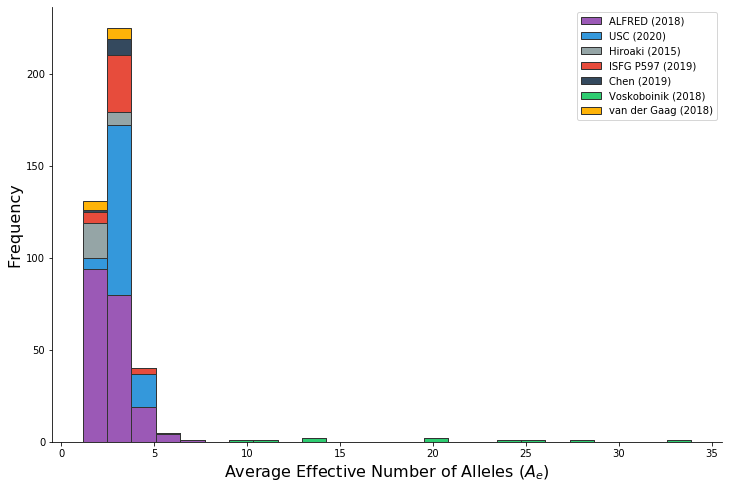

In [18]:
sources = m.Source.unique()
labels = {
    'ALFRED': 'ALFRED (2018)',
    '10.1016/j.fsigen.2019.02.018': 'Chen (2019)',
    '10.1016/j.legalmed.2015.06.003': 'Hiroaki (2015)',
    '10.1016/j.fsigen.2019.102213': 'USC (2020)',
    'ISFG2019:P597': 'ISFG P597 (2019)',
    '10.1016/j.fsigen.2018.05.008': 'van der Gaag (2018)',
    '10.1016/j.fsigen.2018.05.001': 'Voskoboinik (2018)'
}
colors = [
    '#9b59b6',
    '#3498db',
    '#95a5a6',
    '#e74c3c',
    '#34495e',
    '#2ecc71',
    '#feb308',
]
subsets = [m[m.Source == src] for src in sources]
fig = plt.figure(figsize=(12, 8))
fig.patch.set_facecolor('white')
plt.hist([ss.AvgAe for ss in subsets], bins=25, color=colors, edgecolor='#333333', stacked=True, label=[labels[src] for src in sources])
axis = plt.gca()
axis.spines['top'].set_visible(False)
axis.spines['right'].set_visible(False)
axis.set_xlabel('Average Effective Number of Alleles ($A_e$)', fontsize=16)
#xticks = (0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5)
#xticklabels = [10 ** n for n in xticks]
#axis.set_xticks(xticks)
#axis.set_xticklabels(xticklabels)
axis.set_ylabel('Frequency', fontsize=16)
axis.legend()
fig.savefig('mh-ae.pdf')

In [19]:
m[m.AvgAe < 3].shape

(238, 11)

In [20]:
238 / 412

0.5776699029126213

In [22]:
from collections import Counter
Counter([labels[src] for src in m[m.AvgAe < 3].Source])

Counter({'ALFRED (2018)': 136,
         'Hiroaki (2015)': 24,
         'ISFG P597 (2019)': 22,
         'USC (2020)': 39,
         'Chen (2019)': 9,
         'van der Gaag (2018)': 8})

In [23]:
412 - 238

174

In [24]:
157 / 174

0.9022988505747126

In [25]:
m[m.AvgAe > 5].shape

(17, 11)

In [26]:
17 / 412

0.0412621359223301

In [27]:
m[m.Name.isin(['mh20KK-016', 'mh17KK-014', 'mh05KK-120', 'mh02KK-139'])]

,Name,PermID,Reference,Chrom,Offsets,AvgAe,In,Source,Start,End,Length
45,mh02KK-139,MHDBM-b19d2e01,GRCh38,chr2,"108897144,108897197",1.6759,0.4396,ALFRED,108897144,108897198,54
118,mh05KK-120,MHDBM-8472ee43,GRCh38,chr5,"33951445,33951587,33951720",2.0530,0.4857,ALFRED,33951445,33951721,276
330,mh17KK-014,MHDBM-83a239de,GRCh38,chr17,"4497060,4497088,4497096",2.0215,0.6423,ALFRED,4497060,4497097,37
383,mh20KK-016,MHDBM-723361d8,GRCh38,chr20,"63539944,63539991,63540067,63540153,63540202",2.6174,0.6041,ALFRED,63539944,63540203,259


In [29]:
m.sort_values('In', ascending=False).head(20)

,Name,PermID,Reference,Chrom,Offsets,AvgAe,In,Source,Start,End,Length
64,mh03LV-07,MHDBM-5f7e29b6,GRCh38,chr3,"5783508,5783509,5783518,5783523,5783525,578353...",14.0275,1.0810,10.1016/j.fsigen.2018.05.001,5783508,5783706,198
186,mh09LV-02,MHDBM-46974475,GRCh38,chr9,"126716993,126717000,126717001,126717015,126717...",28.0040,0.9683,10.1016/j.fsigen.2018.05.001,126716993,126717336,343
371,mh20LV-04,MHDBM-ee1a008b,GRCh38,chr20,"5665884,5665895,5665899,5665903,5665905,566590...",24.2601,0.9019,10.1016/j.fsigen.2018.05.001,5665884,5666234,350
62,mh03LV-01,MHDBM-75964bf2,GRCh38,chr3,"4567469,4567490,4567512,4567525,4567535,456753...",33.9190,0.8894,10.1016/j.fsigen.2018.05.001,4567469,4567790,321
199,mh10LV-03,MHDBM-e58b05b5,GRCh38,chr10,"16674549,16674557,16674564,16674565,16674607,1...",25.1567,0.8834,10.1016/j.fsigen.2018.05.001,16674549,16674874,325
65,mh03LV-06,MHDBM-a3596593,GRCh38,chr3,"11914400,11914412,11914417,11914424,11914432,1...",20.3159,0.8625,10.1016/j.fsigen.2018.05.001,11914400,11914598,198
56,mh02LV-05,MHDBM-d5e37dff,GRCh38,chr2,"173420586,173420600,173420616,173420625,173420...",20.7826,0.8416,10.1016/j.fsigen.2018.05.001,173420586,173420911,325
141,mh06LV-09,MHDBM-b8f722a9,GRCh38,chr6,"33056354,33056359,33056388,33056400,33056411,3...",10.4354,0.6829,10.1016/j.fsigen.2018.05.001,33056354,33056547,193
330,mh17KK-014,MHDBM-83a239de,GRCh38,chr17,"4497060,4497088,4497096",2.0215,0.6423,ALFRED,4497060,4497097,37
34,mh02LV-08,MHDBM-7b891c73,GRCh38,chr2,"28567654,28567659,28567662,28567673,28567678,2...",13.9066,0.6344,10.1016/j.fsigen.2018.05.001,28567654,28567844,190


In [31]:
m[(m.AvgAe > 1.5) & (m.AvgAe < 5.0)].shape

(383, 11)

In [33]:
m.AvgAe.describe()

count    412.000000
mean       3.278895
std        3.008697
min        1.158200
25%        2.328250
50%        2.864750
75%        3.322100
max       33.919000
Name: AvgAe, dtype: float64

In [35]:
numbers = list(range(100))
numpy.quantile(numbers, 0.95)

94.05

In [41]:
import pandas
numpy.quantile([a for a in m.AvgAe if not pandas.isnull(a)], [0.05, 0.95])

array([1.673515, 4.47637 ])